# Comparison of accuracy on congruent vs. incongruent trials

In [1]:
%cd /Users/Jake/OReilly_Lab/projects/COGS/warp/warp/warped-map/notebooks/

/Users/Jake/OReilly_Lab/projects/COGS/warp/warp/warped-map/notebooks


In [135]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from scipy.stats import binom_test
import statsmodels.api as sm
import statsmodels.formula.api as smf

#### Function for loading results

In [7]:
def load_results(results_fn, accs_type='analyze_accs'):
    results_dir = '../../results/'
    results_path = os.path.join(results_dir,results_fn)
    
    with open(results_path, 'rb') as f:
        data = pickle.load(f)
        
    results = data['results']
    accs = []
    cong_accs = []
    incong_accs = []
    for run in results:
        accs.append([s['acc'] for s in run[accs_type]])
        cong_accs.append([s['cong_acc'] for s in run[accs_type]])
        incong_accs.append([s['incong_acc'] for s in run[accs_type]])
    accs = np.array(accs)
    cong_accs = np.array(cong_accs)
    incong_accs = np.array(incong_accs)
    return accs, cong_accs, incong_accs

## Test whether accuracies are significantly different from chance

Binomial test assuming that samples from all runs are i.i.d.

384 samples (96 neutral, 144 congruent, 144 incongruent)

In [8]:
def binomial_test(accs):
    n = 144
    n_runs, n_checkpoints = accs.shape
    N = n*n_runs # total number of trials
    
    # Convert accuracies to successes
    successes = accs * n
    assert all([s.is_integer() for s in successes.flatten()])
    successes = np.sum(successes, axis=0)
    
    # Binomial test
    p_vals = []
    for s in successes:
        p_val = binom_test(s, N, p=0.5)
        p_vals.append(p_val)
    
    return p_vals # n_steps
    

#### Function for plotting accuracies

In [10]:
def plot_accuracy(cong_accs, incong_accs, cong_p, incong_p, analyze_every, title, save_fn):
    n_runs, n_checkpoints = cong_accs.shape

    # Compute mean and standard deviation for error bars
    cong_mean = np.mean(cong_accs, axis=0)
    incong_mean = np.mean(incong_accs, axis=0)

    cong_sem = np.std(cong_accs, axis=0) / np.sqrt(len(cong_accs))
    incong_sem = np.std(incong_accs, axis=0) / np.sqrt(len(incong_accs))
    
    # Plot
    fig, ax = plt.subplots()
    x = np.arange(n_checkpoints)*analyze_every
    ax.errorbar(x, cong_mean, yerr=cong_sem, c='tab:green')
    ax.errorbar(x, incong_mean, yerr=incong_sem, c='tab:orange')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.ylim([-0.1,1.1])
    plt.title("Accuracy on congruent trials improves first")
    ax.legend(["Congruent", "Incongruent"])
    plt.axhline(y=0.5, color='black', linestyle='--')
    
    # Add asterisks for significance level
    for i in range(n_checkpoints):
        x_coord = x[i]
        y_coord_cong = cong_mean[i]
        y_coord_incong = incong_mean[i]
        if cong_p[i] < 0.05:
            plt.plot(x_coord, y_coord_cong, marker='x', color='blue')
        if incong_p[i] < 0.05:
            plt.plot(x_coord, y_coord_incong, marker='x', color='blue')
    
    
    # Save figure
    if save_fn is not None:
        plt.savefig(save_fn, dpi=1000, format='eps', bbox_inches='tight')
        
    plt.show()

In [12]:
results_fn = 'rnn.P'
accs, cong_accs, incong_accs = load_results(results_fn)
cong_p = binomial_test(cong_accs)
incong_p = binomial_test(incong_accs)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


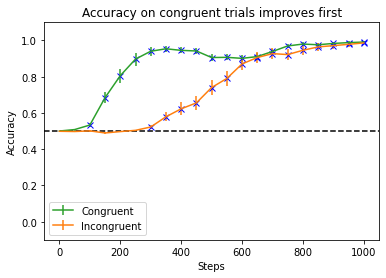

In [13]:
analyze_every = 50
title = "RNN"
save_fn = '../../figures/rnn_cong_incong_acc_train.eps'
plot_accuracy(cong_accs, incong_accs, cong_p, incong_p, analyze_every, title, save_fn)

### Logistic regression to test difference between congruent and incongruent accuracy

In [86]:
# Convert accuracies to correct
assert incong_accs.shape == cong_accs.shape
n_runs, n_steps = cong_accs.shape
n_trials = 144 # 144 congruent trials, 144 incongruent trials
#n_runs = 5

dfs = []
for step_i in range(n_steps):
    run_data = []
    for run_i in range(n_runs):
        cong_acc = cong_accs[run_i, step_i]
        incong_acc = incong_accs[run_i, step_i]
        n_cong_correct = cong_acc * n_trials
        n_incong_correct = incong_acc * n_trials
        assert n_cong_correct.is_integer()
        assert n_incong_correct.is_integer()
        n_cong_correct = int(n_cong_correct)
        n_incong_correct = int(n_incong_correct)
        cong_correct = np.ones([n_cong_correct, 1])
        cong_incorrect = np.zeros([n_trials - n_cong_correct,1])
        incong_correct = np.ones([n_incong_correct,1])
        incong_incorrect = np.zeros([n_trials - n_incong_correct,1])
        
        # make dataframe
        # run_dummy = np.tile(np.eye(run_i), (n_trials*2, 1))
        run_id = run_i * np.ones([2*n_trials,1])
        is_cong = np.concatenate([np.ones([n_trials,1]), 
                                  np.zeros([n_trials,1])], 
                                 axis=0)
        is_correct = np.concatenate([cong_correct, cong_incorrect,
                                     incong_correct, incong_incorrect],
                                    axis=0)
        run = np.concatenate([run_id, is_cong, is_correct], axis=1)
        #run = np.concatenate([is_cong, is_correct], axis=1)
        run_data.append(run)
    step_data = np.concatenate(run_data, axis=0)
    col_names = ["run", "cong", "correct"]
    #col_names = ["cong", "correct"]
    df = pd.DataFrame(step_data, columns=col_names)
    df["run"] = df["run"].astype("category")
    #df["cong"] = df["cong"].astype("category")
    dfs.append(df)

In [87]:
log_regs = []
for df in dfs:
    #log_reg = smf.logit("correct ~ run + cong", data=df).fit()
    log_reg = smf.logit("correct ~ cong", data=df).fit()
    log_regs.append(log_reg)

Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 2
Optimization terminated successfully.
         Current function value: 0.693072
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692034
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.658094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.512128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.433365
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.437108
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.432665
  

In [88]:
for step_i, log_reg in enumerate(log_regs):
    print(f"Step: {step_i*analyze_every}")
    print(log_reg.summary())
    print("\n")

Step: 0
                           Logit Regression Results                           
Dep. Variable:                correct   No. Observations:                 5760
Model:                          Logit   Df Residuals:                     5758
Method:                           MLE   Df Model:                            1
Date:                Wed, 05 Oct 2022   Pseudo R-squ.:               1.392e-06
Time:                        15:55:37   Log-Likelihood:                -3992.5
converged:                       True   LL-Null:                       -3992.5
Covariance Type:            nonrobust   LLR p-value:                    0.9160
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0042      0.037     -0.112      0.911      -0.077       0.069
cong           0.0056      0.053      0.105      0.916      -0.098       0.109


Step: 50
                           Logit 

                           Logit Regression Results                           
Dep. Variable:                correct   No. Observations:                 5760
Model:                          Logit   Df Residuals:                     5758
Method:                           MLE   Df Model:                            1
Date:                Wed, 05 Oct 2022   Pseudo R-squ.:                 0.02723
Time:                        15:55:37   Log-Likelihood:                -1177.3
converged:                       True   LL-Null:                       -1210.2
Covariance Type:            nonrobust   LLR p-value:                 4.704e-16
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4729      0.070     35.543      0.000       2.337       2.609
cong           0.9960      0.129      7.709      0.000       0.743       1.249


Step: 800
                           Logit Regress

In [94]:
logistic_p = [log_reg.pvalues[1] for log_reg in log_regs]

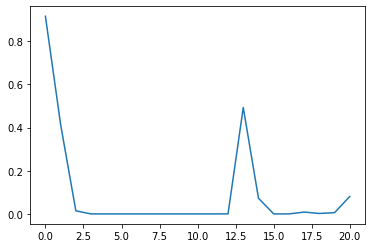

In [96]:
plt.plot(logistic_p)

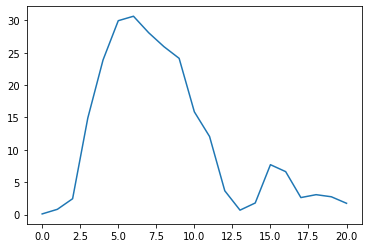

In [197]:
logistic_t = [log_reg.tvalues[1] for log_reg in log_regs]
plt.plot(logistic_t)

In [193]:
def plot_acc_with_logistic_p(cong_accs, incong_accs, logistic_p, 
                             analyze_every, title, save_fn):
    n_runs, n_checkpoints = cong_accs.shape

    # Compute mean and standard deviation for error bars
    cong_mean = np.mean(cong_accs, axis=0)
    incong_mean = np.mean(incong_accs, axis=0)

    cong_sem = np.std(cong_accs, axis=0) / np.sqrt(len(cong_accs))
    incong_sem = np.std(incong_accs, axis=0) / np.sqrt(len(incong_accs))
    
    # Plot
    fig, ax = plt.subplots()
    x = np.arange(n_checkpoints)*analyze_every
    ax.errorbar(x, cong_mean, yerr=cong_sem, c='tab:green')
    ax.errorbar(x, incong_mean, yerr=incong_sem, c='tab:orange')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.ylim([-0.1,1.1])
    plt.title("Accuracy on congruent trials improves first")
    ax.legend(["Congruent", "Incongruent"])
    plt.axhline(y=0.5, color='black', linestyle='--')
    
    # Get spans of significance according to logistic regression
    significant = [p < 0.001 for p in logistic_p]
    sig_spans = []
    mid_span = False
    current_idx = 0
    while current_idx < len(significant):
        if mid_span:
            if not significant[current_idx]:
                stop = current_idx - 1
                sig_spans.append([start, stop])
                mid_span = False
        else:
            if significant[current_idx]:
                start = current_idx
                mid_span = True
        current_idx += 1
        
    # Convert spans from idxs to steps
    sig_spans = [[start*analyze_every, stop*analyze_every] for start, stop in sig_spans]
    
    # Visualize significance with colored area
    for span in sig_spans:
        plt.axvspan(span[0], span[1], color='blue', alpha=0.1)
    
    # Save figure
    if save_fn is not None:
        plt.savefig(save_fn, dpi=1000, format='eps', bbox_inches='tight')
        
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


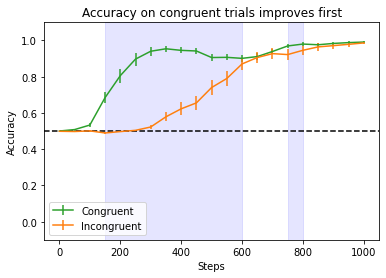

In [194]:
save_fn = '../../figures/rnn_logistic_regression_cong_vs_incong_p001.eps'
plot_acc_with_logistic_p(cong_accs, incong_accs, logistic_p, 
                         analyze_every, title, save_fn)

In [199]:
header = '\t'.join([f"Step{analyze_every*i}" for i in range(len(logistic_p))])
np.savetxt('../../results/tsv/logistic_p.tsv',  logistic_p, 
           delimiter='\t', header=header)
np.savetxt('../../results/tsv/logistic_t.tsv',  logistic_t, 
           delimiter='\t', header=header)

## Relationship between warping and congruent vs. incongruent accuracy

In [164]:
# Load warping data
def load_dist_ratio_results(results_fn, rep_name):
    results_dir = '../../results/'
    results_path = os.path.join(results_dir,results_fn)
    
    with open(results_path, 'rb') as f:
        data = pickle.load(f)
    
    # Get ratio results
    analysis = data['analysis']
    ratios = []
    for run in analysis:
        ratios.append([s['distance_ratio'][rep_name]['ratio'] for s in run])
    dist_ratios = 1 / np.array(ratios)
#     dist_ratios = np.array(ratios)
    
    return dist_ratios

In [165]:
results_fn = 'rnn.P'
rep_name = 'average'

In [166]:
dist_ratios = load_dist_ratio_results(results_fn, rep_name)

In [167]:
# Average over runs
ave_dist_ratios = np.mean(dist_ratios, axis=0)
ave_cong_accs = np.mean(cong_accs, axis=0)
ave_incong_accs = np.mean(incong_accs, axis=0)
ave_acc_ratios = ave_incong_accs / ave_cong_accs
# ave_acc_ratios = ave_cong_accs / ave_incong_accs
lin_time = np.arange(n_steps)

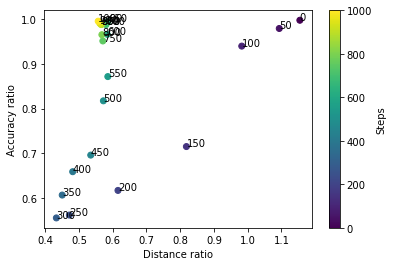

In [201]:
plt.scatter(ave_dist_ratios, ave_acc_ratios, c=analyze_every*lin_time)

labels = [analyze_every*i for i in range(len(ave_dist_ratios))]
for i, label in enumerate(labels):
    plt.annotate(label, (ave_dist_ratios[i], ave_acc_ratios[i]))

plt.xlabel("Distance ratio")
plt.ylabel("Accuracy ratio")
plt.colorbar(label="Steps")
plt.savefig('../../figures/acc_vs_dist_scatter.eps', 
            dpi=1000, format='eps', bbox_inches='tight')
plt.show()

In [185]:
lin_time_ = np.expand_dims(lin_time, axis=1)
ave_dist_ratios_ = np.expand_dims(ave_dist_ratios, axis=1)
interaction = np.expand_dims(lin_time*ave_dist_ratios, axis=1)
x = np.concatenate([lin_time_, ave_dist_ratios_, interaction], axis=1)
x = sm.add_constant(x)
y = ave_acc_ratios

In [186]:
reg = sm.OLS(y,x).fit()

In [187]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     62.58
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           2.15e-09
Time:                        11:08:47   Log-Likelihood:                 34.298
No. Observations:                  21   AIC:                            -60.60
Df Residuals:                      17   BIC:                            -56.42
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0768      0.082      0.941      0.360      -0.095       0.249
x1             0.0087      0.022      0.393      0.699      -0.038       0.056
x2             0.7762      0.099      7.845      0.000       0.567       0.985
x3             0.0340      0.037      0.907      0.377      -0.045       0.113
==============================================================================
Omnibus:                        0.568   Durbin-Watson:                   0.755
Prob(Omnibus):                  0.753   Jarque-Bera (JB):                0.021
Skew:                          -0.044   Prob(JB):                        0.989
Kurtosis:                       3.130   Cond. No.                         154.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""